In [ ]:
!pip install opencv-python mediapipe tensorflow numpy pandas matplotlib scikit-learn tqdm seaborn pyttsx3

In [2]:
# Import Dependencies
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import seaborn as sns
import platform
import pyttsx3

# Data Preprocessing

In [3]:
#Define a helper function to help with preprocessing images and landmarks
def extraction_helper(landmarks, fixed_length=63):
    landmark_list = []
    for landmark in landmarks.multi_hand_landmarks: 
        for i in landmark.landmark:
            #Extract x, y and z components of the hand. Note that z is for depth 
            landmark_list.extend([i.x, i.y, i.z])
    #Add some padding/trimming to desired length
    if len(landmark_list) > fixed_length * 3 : 
        landmark_list = landmark_list[:fixed_length * 3]
    padded_landmarks = pad_sequences([landmark_list], maxlen=fixed_length * 3, padding='post', dtype='float32')[0]

    return padded_landmarks
    

In [5]:
# Process all the images from the kaggle dataset and save them to a pickled file
# Ensure all files have a fixed length of 63 (21 landmarks * 3 coordinates)
train_loc = "Resources/asl_alphabet_train"
test_loc = "Resources/asl_alphabet_train"

def preprocess(train_loc, output_loc, fixed_length=63):
    # Import prebuilt hand extraction model from mediapipe
    hands = mp.solutions.hands 
    hands_extracted = hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.75) #static_image_mode=True means it will process only images, rather than video
    # data = []
    # labels = []
    dataset = {"landmarks": [], "labels": []}
    # Create a list of tuples, where each tuple has the full path to its image file 
    files = [
    (os.path.join(train_loc, dir, img), dir)
    for dir in os.listdir(train_loc)
    if os.path.isdir(os.path.join(train_loc, dir))  # Only process directories
    for img in os.listdir(os.path.join(train_loc, dir))
]

    for path, dir in tqdm(files, desc="Processing", unit='image'): 
        img = cv2.imread(path)
        if img is not None: 
            #Resize so all images are the same size and RGB
            resized = cv2.resize(img, (256,256))
            rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            processed_results = hands_extracted.process(rgb)
            if processed_results.multi_hand_landmarks:
                #Extract all the landmarks from the hand
                padded_landmarks = extraction_helper(processed_results, fixed_length=63)
                dataset["landmarks"].append(padded_landmarks)
                dataset["labels"].append(dir)

    
    #Conver to numpy arrays 
    dataset["landmarks"] = np.array(dataset["landmarks"])
    dataset['labels'] = np.array(dataset['labels'])

    #Save to pickle file 
    with open(output_loc, 'wb') as f:
        pickle.dump(dataset, f)
        # pickle.dump((data, labels), f)

preprocess(train_loc, "fixed_train_data.pkl", fixed_length=63)




I0000 00:00:1739124248.581008   15720 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1739124248.601091   19305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739124248.613427   19305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing: 100%|██████████| 223074/223074 [2:11:41<00:00, 28.23image/s]  


# Visualizing Landmarks

Number of samples: 140569


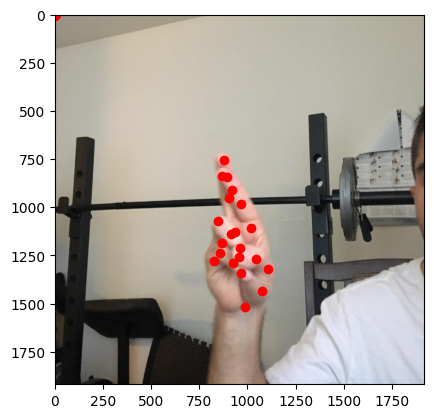

In [6]:
# Load data from pickle file
with open('fixed_train_data.pkl', 'rb') as f:
    dataset = pickle.load(f)
data = dataset['landmarks']
labels = dataset['labels']

# Inspect the data
print("Number of samples:", len(data))

# Function to visualize landmarks on an image
def visualize_landmarks(img_path, landmarks):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    for i in range(0, len(landmarks), 3):
        x = landmarks[i] * img.shape[1]
        y = landmarks[i + 1] * img.shape[0]
        plt.scatter(x, y, c='r', marker='o')
    plt.show()

# Visualize the first sample's landmarks on its image
first_img_path = os.path.join(train_loc, labels[0], os.listdir(os.path.join(train_loc, labels[0]))[0])
visualize_landmarks(first_img_path, data[0])



# Training

In [7]:
# Load data from pickle file
with open('fixed_train_data.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Noramalize data for a range of (0,1)
data = np.array(dataset['landmarks'])
labels = np.array(dataset['labels'])

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)

# Reshape data to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], 63, 3, 1))
X_test = X_test.reshape((X_test.shape[0], 63, 3, 1))

# Build the CNN model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(63, 3, 1)),
    MaxPooling2D(pool_size=(2, 1)),
    Conv2D(64, kernel_size=(3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
training_history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation_loss, evaluation_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Model evaluation loss: {evaluation_loss}, accuracy: {evaluation_accuracy}")

# Save the model
cnn_model.save('ASL_Model.keras')

cnn_model.summary()





/Users/pranavreddy/anaconda3/envs/cnn/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - categorical_accuracy: 0.6829 - loss: 1.1507 - val_categorical_accuracy: 0.9572 - val_loss: 0.1783
Epoch 2/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - categorical_accuracy: 0.9598 - loss: 0.1577 - val_categorical_accuracy: 0.9578 - val_loss: 0.1441
Epoch 3/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - categorical_accuracy: 0.9729 - loss: 0.1053 - val_categorical_accuracy: 0.9752 - val_loss: 0.0892
Epoch 4/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - categorical_accuracy: 0.9788 - loss: 0.0802 - val_categorical_accuracy: 0.9839 - val_loss: 0.0635
Epoch 5/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - categorical_accuracy: 0.9836 - loss: 0.0633 - val_categorical_accuracy: 0.9853 - val_loss: 0.0564
Epoch 6/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - categorical_accuracy: 0.9862 - loss: 0.0519 - val_categorical_accuracy: 0.9880 - val_loss: 0.0479
Epoch 7/30
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - categorical_a

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 3, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 3, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,809 (4.05 MB)

 Trainable params: 354,269 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 708,540 (2.70 MB)

# Validation

In [5]:
train_loc = "Resources/asl_alphabet_train"
test_loc = "Resources/asl_alphabet_test"

In [7]:
def get_label(filename):
    return filename.split('_')[0]

# Loading previously trained model
cnn_model = load_model('ASL_Model.keras')

hands = mp.solutions.hands
hands_extracted = hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

correct_pred = 0
total_pred = 0


for img in os.listdir(test_loc):
    if img.endswith('.jpg'):
        print("Test")
        img_path = os.path.join(test_loc, img)
        image = cv2.imread(img_path)
        if image is not None: 
            img_resized = cv2.resize(image, (256, 256))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            processed_results = hands_extracted.process(img_rgb)
            if processed_results.multi_hand_landmarks: 
                landmarks = np.array(extraction_helper(processed_results, fixed_length=63)).reshape((1, 63, 3, 1))
                print(type(landmarks))

                # Predicting the letter
                pred = cnn_model.predict(landmarks)
                id = np.argmax(pred)
                label = label_encoder.inverse_transform([id])[0]

                # Create real label 
                label_check = get_label(img)

                if label == label_check: 
                    correct_pred += 1
                total_pred += 1

                print(f"Image: {img}, Predicted Value: {label}, Actual Value: {label_check}")

if total_pred > 0: 
    accuracy = correct_pred / total_pred
    print(f"The model accuracy is: {accuracy * 100:.2f}%")
else: 
    print("Error occurred: could not process any valid images")


I0000 00:00:1739211165.988255  267339 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1739211165.999736  445586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739211166.009758  445591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Image: F_test.jpg, Predicted Value: F, Actual Value: F
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: G_test.jpg, Predicted Value: G, Actual Value: G
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: L_test.jpg, Predicted Value: L, Actual Value: L
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: M_test.jpg, Predicted Value: M, Actual Value: M
Test
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: S_test.jpg, Predicted Value: S, Actual Value: S
Test
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: Y_test.jpg, Predicted Value: Y, Actual Value: Y
Test
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: T_test.jpg, Predicted Value: T, Actual Value: T
Test
Test
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: K_test.jpg, Predicted Value: K, Actual Value: K
Tes

KeyboardInterrupt: 

# Evaluation

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.9930 - loss: 0.0402
Test loss: 0.03640160337090492, Test accuracy: 0.9932417869567871
879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


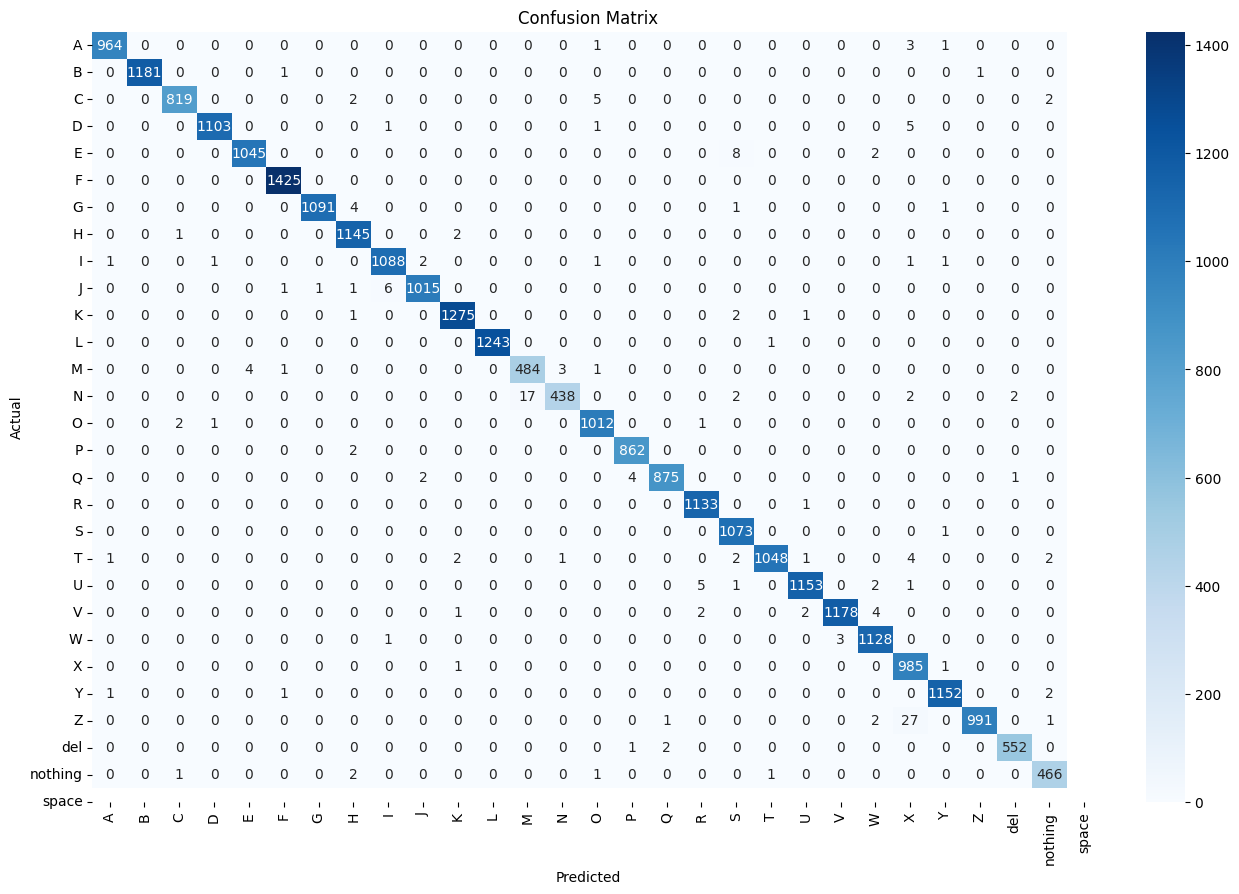

In [10]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

#Prediction Generation
y_perd = cnn_model.predict(X_test)
y_class = np.argmax(y_perd, axis=1)
y_true = np.argmax(y_test, axis=1)

matrix = confusion_matrix(y_true, y_class)
plt.figure(figsize=(16,10))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
# report = classification_report(y_true, y_class, target_names=label_encoder.classes_)
# print(report)

# Running the model on webcam

In [ ]:
cnn_model = load_model('ASL_Model.keras')
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands_extracted = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.3)

# Initialize the voice engine
tts_engine = pyttsx3.init()
#Adjust speed
tts_engine.setProperty('rate', 190)
#Max volume 
tts_engine.setProperty('volume', 2.0)
last_spoken = None 


# Label encoder to convert numerical labels back to original labels
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

# Initialize webcam
if platform.system() == 'Darwin':
    # Capture video from webcam for mac users
    cap = cv2.VideoCapture(1, cv2.CAP_AVFOUNDATION)
else:
    # Capture video from webcam for windows users
    cap = cv2.VideoCapture(0)

# Loop to capture frames from the webcam
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get the width of the frame
    frame_width = frame.shape[1]

    # Convert the BGR image to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to detect hands
    processed_results = hands_extracted.process(img_rgb)

    # Calculate the width of the quit text
    quit_text = "Press q to quit"
    quit_font = cv2.FONT_HERSHEY_SIMPLEX
    quit_scale = 1
    quit_thickness = 2
    (quit_width, quit_height), _ = cv2.getTextSize(quit_text, quit_font, quit_scale, quit_thickness)

    # Calculate the x-coordinate for the predicted letter (left side)
    label_x = 10  # Fixed padding from the left edge

    # Calculate the x-coordinate for the "Press q to quit" text (right side)
    quit_x = frame_width - quit_width - 20  # Fixed padding from the right edge


     # Display the quit text on the right side
    cv2.putText(frame, quit_text, (quit_x, 70), quit_font, quit_scale, (0, 255, 0), quit_thickness, cv2.LINE_AA)

    if processed_results.multi_hand_landmarks:
        # Preprocess landmarks for prediction
        landmarks = np.array(extraction_helper(processed_results, fixed_length=63)).reshape((1, 63, 3, 1))

        # Predict the letter
        pred = cnn_model.predict(landmarks)
        id = np.argmax(pred)
        label = label_encoder.inverse_transform([id])[0]

        # Draw the landmarks and label on the frame
        for hand_landmarks in processed_results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        # Calculate the width of the predicted letter text
        label_text = label
        label_font = cv2.FONT_HERSHEY_SIMPLEX 
        label_scale = 2
        label_thickness = 3
        (label_width, label_height), _ = cv2.getTextSize(label_text, label_font, label_scale, label_thickness)

         # Calculate the confidence percentage
        confidence = np.max(pred) * 100

        if confidence < 75:
            colour = (0, 0, 255)  # Red
        else: 
            colour = (0, 255, 0)  # Green

        # Display the predicted letter on the left side
        cv2.putText(frame, label_text, (label_x, 70), label_font, label_scale, colour, label_thickness, cv2.LINE_AA)


        # Format the confidence text
        confidence_text = f"Confidence: {confidence:.2f}%"

        # Calculate the y-coordinate for the confidence text (below the predicted letter)
        confidence_y = 70 + label_height + 20  # Add 10 pixels padding between the two lines

        # Display the confidence text below the predicted letter
        cv2.putText(frame, confidence_text, (label_x, confidence_y), quit_font, quit_scale, colour, quit_thickness, cv2.LINE_AA)

        if label != last_spoken and confidence >= 75:
            tts_engine.say(label)
            tts_engine.runAndWait()
            last_spoken = label  # Update last spoken letter

    # Display the frame
    cv2.imshow('ASL Sign Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1739211377.855008  267339 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1739211377.866540  453556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739211377.873076  453552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

: 